In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.25,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_025_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 920)
(734160, 1)
validation
(101248, 920)
(101248, 1)
test
(100432, 920)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 1024)              943104    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1632257 (6.23 MB)


Trainable params: 1632257 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/735 [..............................] - ETA: 12:34 - loss: 0.0294 - STD: 1.2777e-04 - MAE: 0.1536

 14/735 [..............................] - ETA: 2s - loss: 0.0151 - STD: 1.7436e-04 - MAE: 0.0956   

 26/735 [>.............................] - ETA: 2s - loss: 0.0127 - STD: 1.8955e-04 - MAE: 0.0868

 39/735 [>.............................] - ETA: 2s - loss: 0.0116 - STD: 2.3397e-04 - MAE: 0.0833

 52/735 [=>............................] - ETA: 2s - loss: 0.0110 - STD: 2.9562e-04 - MAE: 0.0813

 64/735 [=>............................] - ETA: 2s - loss: 0.0106 - STD: 3.7893e-04 - MAE: 0.0799

 76/735 [==>...........................] - ETA: 2s - loss: 0.0104 - STD: 5.1426e-04 - MAE: 0.0792

 90/735 [==>...........................] - ETA: 2s - loss: 0.0101 - STD: 8.1217e-04 - MAE: 0.0784

 96/735 [==>...........................] - ETA: 5s - loss: 0.0101 - STD: 0.0010 - MAE: 0.0781    

108/735 [===>..........................] - ETA: 4s - loss: 0.0099 - STD: 0.0019 - MAE: 0.0776

120/735 [===>..........................] - ETA: 4s - loss: 0.0097 - STD: 0.0039 - MAE: 0.0769

132/735 [====>.........................] - ETA: 4s - loss: 0.0095 - STD: 0.0071 - MAE: 0.0759

144/735 [====>.........................] - ETA: 4s - loss: 0.0092 - STD: 0.0102 - MAE: 0.0749

156/735 [=====>........................] - ETA: 3s - loss: 0.0090 - STD: 0.0132 - MAE: 0.0739

171/735 [=====>........................] - ETA: 3s - loss: 0.0088 - STD: 0.0167 - MAE: 0.0728

186/735 [======>.......................] - ETA: 3s - loss: 0.0085 - STD: 0.0198 - MAE: 0.0716

201/735 [=======>......................] - ETA: 3s - loss: 0.0083 - STD: 0.0225 - MAE: 0.0704

213/735 [=======>......................] - ETA: 3s - loss: 0.0081 - STD: 0.0246 - MAE: 0.0696

226/735 [========>.....................] - ETA: 2s - loss: 0.0079 - STD: 0.0268 - MAE: 0.0688

238/735 [========>.....................] - ETA: 2s - loss: 0.0078 - STD: 0.0285 - MAE: 0.0682

250/735 [=========>....................] - ETA: 2s - loss: 0.0077 - STD: 0.0302 - MAE: 0.0675

263/735 [=========>....................] - ETA: 2s - loss: 0.0076 - STD: 0.0318 - MAE: 0.0669

276/735 [==========>...................] - ETA: 2s - loss: 0.0074 - STD: 0.0333 - MAE: 0.0663

288/735 [==========>...................] - ETA: 2s - loss: 0.0073 - STD: 0.0346 - MAE: 0.0658

300/735 [===========>..................] - ETA: 2s - loss: 0.0073 - STD: 0.0357 - MAE: 0.0654

313/735 [===========>..................] - ETA: 2s - loss: 0.0072 - STD: 0.0369 - MAE: 0.0649

328/735 [============>.................] - ETA: 2s - loss: 0.0071 - STD: 0.0381 - MAE: 0.0644

344/735 [=============>................] - ETA: 2s - loss: 0.0070 - STD: 0.0394 - MAE: 0.0639

357/735 [=============>................] - ETA: 1s - loss: 0.0069 - STD: 0.0403 - MAE: 0.0635

369/735 [==============>...............] - ETA: 1s - loss: 0.0068 - STD: 0.0411 - MAE: 0.0632

382/735 [==============>...............] - ETA: 1s - loss: 0.0068 - STD: 0.0419 - MAE: 0.0629

395/735 [===============>..............] - ETA: 1s - loss: 0.0067 - STD: 0.0427 - MAE: 0.0625

407/735 [===============>..............] - ETA: 1s - loss: 0.0066 - STD: 0.0434 - MAE: 0.0622

418/735 [================>.............] - ETA: 1s - loss: 0.0066 - STD: 0.0439 - MAE: 0.0620

430/735 [================>.............] - ETA: 1s - loss: 0.0065 - STD: 0.0445 - MAE: 0.0617

444/735 [=================>............] - ETA: 1s - loss: 0.0065 - STD: 0.0452 - MAE: 0.0614

459/735 [=================>............] - ETA: 1s - loss: 0.0064 - STD: 0.0459 - MAE: 0.0611

471/735 [==================>...........] - ETA: 1s - loss: 0.0064 - STD: 0.0464 - MAE: 0.0609

483/735 [==================>...........] - ETA: 1s - loss: 0.0063 - STD: 0.0468 - MAE: 0.0607

498/735 [===================>..........] - ETA: 1s - loss: 0.0063 - STD: 0.0474 - MAE: 0.0605

514/735 [===================>..........] - ETA: 1s - loss: 0.0062 - STD: 0.0480 - MAE: 0.0602

526/735 [====================>.........] - ETA: 1s - loss: 0.0062 - STD: 0.0484 - MAE: 0.0600

538/735 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0488 - MAE: 0.0598

550/735 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0492 - MAE: 0.0596

562/735 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0495 - MAE: 0.0595

574/735 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0499 - MAE: 0.0593

586/735 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0502 - MAE: 0.0591

599/735 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0506 - MAE: 0.0590

612/735 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0509 - MAE: 0.0588

625/735 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0513 - MAE: 0.0587

640/735 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0517 - MAE: 0.0585

654/735 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0519 - MAE: 0.0583

665/735 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0522 - MAE: 0.0582

677/735 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0525 - MAE: 0.0581

691/735 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0528 - MAE: 0.0579

705/735 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0532 - MAE: 0.0578

718/735 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0534 - MAE: 0.0577

732/735 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0537 - MAE: 0.0575

735/735 [==============================] - 5s 5ms/step - loss: 0.0057 - STD: 0.0538 - MAE: 0.0575 - val_loss: 0.0037 - val_STD: 0.0505 - val_MAE: 0.0466


Epoch 2/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0497

 14/735 [..............................] - ETA: 2s - loss: 0.0045 - STD: 0.0686 - MAE: 0.0505 

 28/735 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0687 - MAE: 0.0508

 41/735 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0503

 57/735 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0692 - MAE: 0.0504

 73/735 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0505

 88/735 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0687 - MAE: 0.0505

104/735 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0507

119/735 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0509

134/735 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0508

149/735 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0680 - MAE: 0.0508

164/735 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0507

179/735 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0506

194/735 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0506

209/735 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0506

224/735 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0505

239/735 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0505

254/735 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0504

270/735 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0504

286/735 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0504

302/735 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0503

319/735 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0503

335/735 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0503

350/735 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0502

365/735 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0502

381/735 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0501

396/735 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0501

411/735 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0500

427/735 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0501

442/735 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0500

457/735 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0500

473/735 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0500

488/735 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0499

503/735 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0499

519/735 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0499

534/735 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0498

549/735 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

564/735 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0497

579/735 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

594/735 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

610/735 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0497

626/735 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0497

642/735 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0496

658/735 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0496

674/735 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

689/735 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0496

706/735 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

723/735 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0495

735/735 [==============================] - 3s 4ms/step - loss: 0.0043 - STD: 0.0693 - MAE: 0.0494 - val_loss: 0.0034 - val_STD: 0.0518 - val_MAE: 0.0437


Epoch 3/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

 15/735 [..............................] - ETA: 2s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0475 

 27/735 [>.............................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

 40/735 [>.............................] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0477

 55/735 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0474

 72/735 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

 85/735 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

100/735 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

116/735 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

132/735 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0475

147/735 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0477

162/735 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0477

177/735 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0477

193/735 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0476

207/735 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

224/735 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0475

238/735 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0474

250/735 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0475

262/735 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0475

275/735 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0474

291/735 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0474

306/735 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0474

320/735 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0474

335/735 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0473

350/735 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0473

365/735 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0473

380/735 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0473

395/735 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0473

409/735 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0473

424/735 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0472

438/735 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0472

454/735 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0472

469/735 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0471

484/735 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0471

499/735 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0471

515/735 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0470

531/735 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0470

546/735 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0469

562/735 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0469

578/735 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0469

593/735 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0469

608/735 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0469

624/735 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0469

640/735 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

655/735 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

670/735 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

685/735 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

701/735 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

717/735 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0467

733/735 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0467

735/735 [==============================] - 3s 4ms/step - loss: 0.0039 - STD: 0.0725 - MAE: 0.0467 - val_loss: 0.0032 - val_STD: 0.0576 - val_MAE: 0.0418


Epoch 4/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0454

 13/735 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0451 

 25/735 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0451

 38/735 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0742 - MAE: 0.0461

 51/735 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0462

 64/735 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0458

 76/735 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0457

 91/735 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

107/735 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0458

123/735 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0457

137/735 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0456

149/735 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0456

161/735 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0455

173/735 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

185/735 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

197/735 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

209/735 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

220/735 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

232/735 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

246/735 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

260/735 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

275/735 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

291/735 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

304/735 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

318/735 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

335/735 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

350/735 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

365/735 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

380/735 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

396/735 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

412/735 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

429/735 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0452

442/735 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0451

454/735 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0451

465/735 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0451

478/735 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0451

491/735 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0451

503/735 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0451

517/735 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0451

528/735 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

541/735 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

552/735 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

564/735 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0450

576/735 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

590/735 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

606/735 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

619/735 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

635/735 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0449

650/735 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0449

666/735 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

680/735 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

692/735 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

707/735 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

723/735 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

735/735 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

735/735 [==============================] - 3s 4ms/step - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448 - val_loss: 0.0035 - val_STD: 0.0558 - val_MAE: 0.0424


Epoch 5/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0033 - STD: 0.0688 - MAE: 0.0413

 15/735 [..............................] - ETA: 2s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0445 

 30/735 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0441

 43/735 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0440

 55/735 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0440

 68/735 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0440

 84/735 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

 99/735 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0439

114/735 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0438

126/735 [====>.........................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0437

138/735 [====>.........................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0437

151/735 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

163/735 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0436

175/735 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

187/735 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0435

199/735 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0435

210/735 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

222/735 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

236/735 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

247/735 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

258/735 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

270/735 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

282/735 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

294/735 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

306/735 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

318/735 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

331/735 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

344/735 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

356/735 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

367/735 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

378/735 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

390/735 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

402/735 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

417/735 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

433/735 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

450/735 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

467/735 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

484/735 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

500/735 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

517/735 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

533/735 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

550/735 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

566/735 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

582/735 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

598/735 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

614/735 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

630/735 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

647/735 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

664/735 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

681/735 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

698/735 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

715/735 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

732/735 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

735/735 [==============================] - 3s 4ms/step - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432 - val_loss: 0.0030 - val_STD: 0.0619 - val_MAE: 0.0409


Epoch 6/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0428

 11/735 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0735 - MAE: 0.0425 

 23/735 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0749 - MAE: 0.0428

 36/735 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0751 - MAE: 0.0430

 48/735 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0430

 60/735 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

 72/735 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

 84/735 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

 96/735 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

109/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0424

124/735 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0424

139/735 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0423

150/735 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

162/735 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0423

174/735 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

186/735 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

198/735 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

211/735 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

225/735 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

238/735 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

252/735 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

264/735 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

276/735 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

289/735 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

304/735 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

320/735 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

335/735 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

350/735 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

364/735 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

378/735 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

393/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

407/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

422/735 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

437/735 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

452/735 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

468/735 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

484/735 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

497/735 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

512/735 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

526/735 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

541/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

553/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

566/735 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

581/735 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

597/735 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

613/735 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

629/735 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

641/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

653/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

666/735 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

678/735 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

691/735 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

705/735 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

719/735 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

731/735 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

735/735 [==============================] - 3s 4ms/step - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419 - val_loss: 0.0037 - val_STD: 0.0566 - val_MAE: 0.0438


Epoch 7/10000


  1/735 [..............................] - ETA: 21s - loss: 0.0028 - STD: 0.0669 - MAE: 0.0390

 14/735 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0418 

 29/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0758 - MAE: 0.0416

 44/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0413

 59/735 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0413

 75/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0415

 91/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0420

107/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0419

123/735 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0419

139/735 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0418

152/735 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0417

167/735 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0416

183/735 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0416

198/735 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0416

213/735 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0416

226/735 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0415

240/735 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

256/735 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

272/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

288/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

305/735 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

321/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

337/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

353/735 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

370/735 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

386/735 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

402/735 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

417/735 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

433/735 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

449/735 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

464/735 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

480/735 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

496/735 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

513/735 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

528/735 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

541/735 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

555/735 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

570/735 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

583/735 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

597/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

609/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

622/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

633/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

644/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

658/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

674/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

690/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

705/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

721/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

735/735 [==============================] - 3s 4ms/step - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410 - val_loss: 0.0029 - val_STD: 0.0675 - val_MAE: 0.0398


Epoch 8/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0408

 16/735 [..............................] - ETA: 2s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0408 

 32/735 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

 48/735 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0406

 64/735 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

 80/735 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

 96/735 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

112/735 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

128/735 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

145/735 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

162/735 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

179/735 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

195/735 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

211/735 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

227/735 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

243/735 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

259/735 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

275/735 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

291/735 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

308/735 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

325/735 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

341/735 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

357/735 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

373/735 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

389/735 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

405/735 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

420/735 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

435/735 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

450/735 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

465/735 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

480/735 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

495/735 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

511/735 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

527/735 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

543/735 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

559/735 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0402

575/735 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

591/735 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

607/735 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

623/735 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

639/735 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

655/735 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

671/735 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

686/735 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

702/735 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

719/735 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

734/735 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

735/735 [==============================] - 3s 4ms/step - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402 - val_loss: 0.0029 - val_STD: 0.0615 - val_MAE: 0.0393


Epoch 9/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0030 - STD: 0.0729 - MAE: 0.0402

 16/735 [..............................] - ETA: 2s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0405 

 32/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0766 - MAE: 0.0410

 49/735 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0404

 66/735 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0402

 82/735 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0400

 99/735 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0400

115/735 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

129/735 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

145/735 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

162/735 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

178/735 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0401

194/735 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0401

210/735 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0401

226/735 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0401

241/735 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0401

253/735 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

267/735 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0400

283/735 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0400

297/735 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

311/735 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

327/735 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

344/735 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0400

360/735 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0400

375/735 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0400

390/735 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

401/735 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

413/735 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

425/735 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

438/735 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

452/735 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

468/735 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

485/735 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

501/735 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

518/735 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

535/735 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

552/735 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

568/735 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

584/735 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

596/735 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

608/735 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

623/735 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

640/735 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

657/735 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

674/735 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

691/735 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

707/735 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

724/735 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

735/735 [==============================] - 3s 4ms/step - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397 - val_loss: 0.0031 - val_STD: 0.0718 - val_MAE: 0.0411


Epoch 10/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0035 - STD: 0.0876 - MAE: 0.0445

 15/735 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0777 - MAE: 0.0396 

 29/735 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

 43/735 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

 56/735 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

 69/735 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

 82/735 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

 94/735 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

106/735 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

119/735 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

134/735 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

146/735 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

158/735 [=====>........................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

170/735 [=====>........................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

182/735 [======>.......................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

195/735 [======>.......................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

207/735 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

219/735 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

234/735 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

248/735 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

263/735 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

279/735 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

295/735 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

310/735 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

327/735 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

342/735 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

358/735 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

373/735 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

387/735 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

401/735 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

416/735 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

432/735 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

447/735 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

462/735 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

476/735 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

491/735 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

506/735 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

521/735 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

535/735 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

548/735 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

563/735 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

576/735 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

587/735 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

599/735 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

611/735 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

623/735 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

635/735 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

648/735 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

663/735 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

677/735 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

689/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

701/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

713/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

725/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

735/735 [==============================] - 3s 4ms/step - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389 - val_loss: 0.0029 - val_STD: 0.0656 - val_MAE: 0.0394


Epoch 11/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0026 - STD: 0.0770 - MAE: 0.0380

 14/735 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.0807 - MAE: 0.0391 

 26/735 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0807 - MAE: 0.0390

 38/735 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0391

 53/735 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0391

 67/735 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0391

 80/735 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

 95/735 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

110/735 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

125/735 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0387

141/735 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0387

154/735 [=====>........................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

169/735 [=====>........................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

184/735 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

200/735 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

215/735 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

228/735 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

243/735 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

258/735 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

273/735 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

287/735 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

300/735 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

314/735 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

329/735 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

346/735 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

362/735 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

377/735 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

393/735 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

405/735 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

417/735 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

429/735 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

441/735 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

453/735 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

465/735 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

477/735 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

490/735 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

501/735 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

512/735 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

527/735 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

542/735 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

558/735 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

574/735 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

590/735 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

606/735 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

622/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

637/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

650/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

662/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

675/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

690/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

706/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

721/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

735/735 [==============================] - 3s 4ms/step - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383 - val_loss: 0.0029 - val_STD: 0.0711 - val_MAE: 0.0393


Epoch 12/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0026 - STD: 0.0908 - MAE: 0.0382

 13/735 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0815 - MAE: 0.0389 

 28/735 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0386

 44/735 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

 59/735 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0380

 75/735 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

 91/735 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0379

107/735 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0379

123/735 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0378

138/735 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0378

153/735 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0378

169/735 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0378

185/735 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0378

201/735 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0378

217/735 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0378

232/735 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0378

247/735 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0379

263/735 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0380

278/735 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0380

293/735 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0380

309/735 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0380

324/735 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0380

340/735 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0380

355/735 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0380

371/735 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0380

387/735 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0380

402/735 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0380

417/735 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0380

432/735 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0379

448/735 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0379

464/735 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0379

481/735 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0379

498/735 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0378

514/735 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0378

529/735 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0379

544/735 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0378

559/735 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0378

575/735 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0378

591/735 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0378

608/735 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0378

623/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0378

638/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0377

655/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0377

671/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0377

687/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0377

703/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0377

720/735 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0377

735/735 [==============================] - 3s 4ms/step - loss: 0.0026 - STD: 0.0809 - MAE: 0.0377 - val_loss: 0.0033 - val_STD: 0.0649 - val_MAE: 0.0417


Epoch 13/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0408

 14/735 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0809 - MAE: 0.0388 

 29/735 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0809 - MAE: 0.0383

 45/735 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0379

 61/735 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0376

 74/735 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

 86/735 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0373

100/735 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

116/735 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373

132/735 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

148/735 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

164/735 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

180/735 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

195/735 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

208/735 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

223/735 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

238/735 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

254/735 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0374

267/735 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0374

278/735 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

291/735 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

307/735 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

322/735 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

338/735 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

353/735 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

369/735 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

385/735 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

401/735 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0374

417/735 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0374

433/735 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0374

448/735 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0374

464/735 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0373

479/735 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0373

494/735 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373

510/735 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373

525/735 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373

540/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0373

556/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0374

572/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0374

588/735 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

601/735 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

614/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0374

626/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0373

641/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373

657/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373

673/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373

688/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373

702/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373

713/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373

725/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373

735/735 [==============================] - 3s 4ms/step - loss: 0.0025 - STD: 0.0811 - MAE: 0.0373 - val_loss: 0.0029 - val_STD: 0.0679 - val_MAE: 0.0395


Epoch 14/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0384

 15/735 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0358 

 27/735 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0359

 40/735 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0361

 54/735 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0362

 69/735 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0362

 84/735 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0364

 97/735 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0365

109/735 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0365

123/735 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0363

139/735 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0364

151/735 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0365

163/735 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0365

175/735 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0366

187/735 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0367

201/735 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

213/735 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0368

224/735 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

235/735 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

247/735 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0368

260/735 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0368

275/735 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0368

290/735 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0367

305/735 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0367

320/735 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0367

335/735 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

349/735 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

363/735 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0368

375/735 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0368

388/735 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0368

402/735 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0368

417/735 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0367

433/735 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0367

448/735 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0367

463/735 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0367

477/735 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

492/735 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

507/735 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

520/735 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

534/735 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

547/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

559/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

572/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0367

585/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

597/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

610/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

623/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

637/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

649/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

661/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

674/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

688/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

702/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

716/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

728/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

735/735 [==============================] - 3s 4ms/step - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367 - val_loss: 0.0030 - val_STD: 0.0700 - val_MAE: 0.0395


Epoch 15/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0356

 13/735 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0380 

 25/735 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

 37/735 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0373

 52/735 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

 68/735 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

 81/735 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

 94/735 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

106/735 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

118/735 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

130/735 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

143/735 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

155/735 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

167/735 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0366

179/735 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0365

190/735 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0365

203/735 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0365

217/735 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0365

231/735 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0365

242/735 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0364

254/735 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0364

265/735 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0365

277/735 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0365

290/735 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0366

304/735 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0366

317/735 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0366

328/735 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0366

340/735 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0366

352/735 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0366

364/735 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0366

376/735 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

389/735 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

402/735 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

414/735 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

426/735 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0366

438/735 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0366

451/735 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0366

467/735 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0366

484/735 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0365

499/735 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0365

514/735 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0365

528/735 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0365

541/735 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0365

553/735 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0365

565/735 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0364

580/735 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0365

595/735 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0365

608/735 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0365

624/735 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0364

637/735 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0364

651/735 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0364

667/735 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0364

683/735 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0364

699/735 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0364

714/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0364

728/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0363

735/735 [==============================] - 3s 4ms/step - loss: 0.0024 - STD: 0.0820 - MAE: 0.0363 - val_loss: 0.0028 - val_STD: 0.0679 - val_MAE: 0.0390


Epoch 16/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0021 - STD: 0.0819 - MAE: 0.0347

 13/735 [..............................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354 

 26/735 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0353

 39/735 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

 52/735 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

 64/735 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

 76/735 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

 87/735 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

100/735 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

114/735 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0357

125/735 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0357

140/735 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0358

155/735 [=====>........................] - ETA: 2s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0358

170/735 [=====>........................] - ETA: 2s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0358

187/735 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0358

203/735 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0358

219/735 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

235/735 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

249/735 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

264/735 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

277/735 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

290/735 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

306/735 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

322/735 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

337/735 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

354/735 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

370/735 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

386/735 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0358

403/735 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0358

419/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0358

435/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0358

451/735 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0358

465/735 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0358

480/735 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

494/735 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

510/735 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

526/735 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

541/735 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

556/735 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

570/735 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

585/735 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

597/735 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

609/735 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0358

621/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0358

633/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0358

646/735 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0358

662/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0358

678/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0358

694/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0358

706/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0358

718/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0358

729/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0358

735/735 [==============================] - 3s 4ms/step - loss: 0.0023 - STD: 0.0825 - MAE: 0.0357 - val_loss: 0.0029 - val_STD: 0.0669 - val_MAE: 0.0391


Epoch 17/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0020 - STD: 0.0782 - MAE: 0.0345

 14/735 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0360 

 29/735 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0367

 44/735 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

 60/735 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0368

 74/735 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0367

 87/735 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0365

101/735 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0363

113/735 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0362

125/735 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0361

136/735 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0360

148/735 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

163/735 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

178/735 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

195/735 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

209/735 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0358

221/735 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0358

233/735 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0358

245/735 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0358

258/735 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0358

269/735 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0359

281/735 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0359

295/735 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0358

308/735 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0358

321/735 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0357

333/735 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0357

346/735 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0357

362/735 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0357

377/735 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0357

393/735 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0357

407/735 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0357

421/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0356

432/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0356

446/735 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0356

459/735 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

471/735 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0356

483/735 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0356

495/735 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

506/735 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

521/735 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

533/735 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

545/735 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

558/735 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0355

570/735 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

582/735 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0355

593/735 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0355

606/735 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0355

620/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0355

631/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0355

643/735 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0355

658/735 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

675/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

691/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

707/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

722/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

735/735 [==============================] - 3s 4ms/step - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354 - val_loss: 0.0030 - val_STD: 0.0619 - val_MAE: 0.0397


Epoch 18/10000


  1/735 [..............................] - ETA: 17s - loss: 0.0026 - STD: 0.0732 - MAE: 0.0371

 15/735 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0361 

 30/735 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0361

 45/735 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0358

 60/735 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0355

 76/735 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

 92/735 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0357

104/735 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356

116/735 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

130/735 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

145/735 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

160/735 [=====>........................] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

175/735 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

190/735 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

206/735 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

222/735 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

237/735 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

252/735 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

268/735 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

283/735 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

299/735 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

315/735 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

330/735 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

345/735 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

361/735 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

376/735 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

392/735 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

408/735 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

423/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

439/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

455/735 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

470/735 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

485/735 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

501/735 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

517/735 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

533/735 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

549/735 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

565/735 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0351

580/735 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0351

596/735 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0351

610/735 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0351

623/735 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0351

639/735 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0350

655/735 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0350

670/735 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0350

686/735 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0350

702/735 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0350

717/735 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0350

732/735 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0350

735/735 [==============================] - 3s 4ms/step - loss: 0.0022 - STD: 0.0831 - MAE: 0.0350 - val_loss: 0.0028 - val_STD: 0.0710 - val_MAE: 0.0389


Epoch 19/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0022 - STD: 0.0877 - MAE: 0.0351

 15/735 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0348 

 30/735 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.0826 - MAE: 0.0343

 45/735 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0343

 61/735 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.0831 - MAE: 0.0344

 77/735 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0348

 93/735 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0347

109/735 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0347

125/735 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0346

139/735 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0345

155/735 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0345

170/735 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

183/735 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

200/735 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346

216/735 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

232/735 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

248/735 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

263/735 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0346

279/735 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

295/735 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

312/735 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

328/735 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

344/735 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0346

360/735 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0346

376/735 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0346

391/735 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0346

406/735 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

422/735 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

438/735 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

454/735 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0346

470/735 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0346

485/735 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0346

500/735 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0346

516/735 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

532/735 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0346

548/735 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

564/735 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0346

580/735 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0346

597/735 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0346

613/735 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

630/735 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

647/735 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

662/735 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

678/735 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

693/735 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

708/735 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

724/735 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

735/735 [==============================] - 3s 4ms/step - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345 - val_loss: 0.0027 - val_STD: 0.0689 - val_MAE: 0.0381


Epoch 20/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0020 - STD: 0.0833 - MAE: 0.0330

 13/735 [..............................] - ETA: 3s - loss: 0.0021 - STD: 0.0846 - MAE: 0.0339 

 25/735 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0347

 37/735 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0346

 48/735 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0345

 60/735 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0345

 74/735 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0343

 89/735 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0343

104/735 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0342

119/735 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0342

134/735 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0341

149/735 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0341

164/735 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0341

179/735 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0341

192/735 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0340

207/735 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0340

222/735 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0340

237/735 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0340

250/735 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0340

264/735 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0340

277/735 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0340

290/735 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0340

305/735 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0341

320/735 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0342

335/735 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0342

347/735 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0342

362/735 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0342

379/735 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0342

396/735 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0342

411/735 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0342

427/735 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0342

442/735 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0342

457/735 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0342

472/735 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0342

487/735 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0342

503/735 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0342

519/735 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0342

534/735 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0342

550/735 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0342

566/735 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0342

581/735 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0342

597/735 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0342

613/735 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0343

628/735 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0343

644/735 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0342

659/735 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0343

675/735 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0343

690/735 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0343

705/735 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0342

721/735 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0342

735/735 [==============================] - 3s 4ms/step - loss: 0.0021 - STD: 0.0838 - MAE: 0.0342 - val_loss: 0.0028 - val_STD: 0.0714 - val_MAE: 0.0384


Epoch 21/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0020 - STD: 0.0878 - MAE: 0.0339

 16/735 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0847 - MAE: 0.0338 

 31/735 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.0845 - MAE: 0.0336

 46/735 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0336

 61/735 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.0848 - MAE: 0.0336

 76/735 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.0846 - MAE: 0.0337

 91/735 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.0845 - MAE: 0.0336

105/735 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0338

120/735 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0339

135/735 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0338

150/735 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

165/735 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0338

179/735 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0338

195/735 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0338

210/735 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0338

225/735 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

240/735 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0338

254/735 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0338

268/735 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0338

284/735 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0338

300/735 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

315/735 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

332/735 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

349/735 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

366/735 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

382/735 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0338

399/735 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

416/735 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

433/735 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

450/735 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

467/735 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

484/735 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

500/735 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

516/735 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

532/735 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

548/735 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

564/735 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

580/735 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

596/735 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

612/735 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

628/735 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

643/735 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

659/735 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

675/735 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

691/735 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

708/735 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

725/735 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

735/735 [==============================] - 3s 4ms/step - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337 - val_loss: 0.0029 - val_STD: 0.0680 - val_MAE: 0.0387


Epoch 22/10000


  1/735 [..............................] - ETA: 17s - loss: 0.0018 - STD: 0.0795 - MAE: 0.0316

 12/735 [..............................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0330 

 27/735 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0840 - MAE: 0.0332

 43/735 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

 59/735 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0333

 75/735 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0334

 91/735 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0334

106/735 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0335

121/735 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

136/735 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0335

151/735 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0335

166/735 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0335

181/735 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

197/735 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0335

213/735 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

229/735 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0840 - MAE: 0.0335

244/735 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0335

260/735 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

275/735 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0335

290/735 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0335

304/735 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

318/735 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

334/735 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

350/735 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

366/735 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

383/735 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

400/735 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

416/735 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

432/735 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0335

448/735 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0335

464/735 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0335

480/735 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0335

497/735 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0335

513/735 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0335

530/735 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0335

547/735 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0335

563/735 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0334

579/735 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0334

595/735 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0334

611/735 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0334

626/735 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0334

641/735 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0334

657/735 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0334

672/735 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0334

688/735 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0335

704/735 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0335

720/735 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0334

735/735 [==============================] - 3s 4ms/step - loss: 0.0020 - STD: 0.0844 - MAE: 0.0334 - val_loss: 0.0029 - val_STD: 0.0664 - val_MAE: 0.0387


Epoch 23/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0019 - STD: 0.0809 - MAE: 0.0320

 14/735 [..............................] - ETA: 2s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0332 

 26/735 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0335

 38/735 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0335

 50/735 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.0840 - MAE: 0.0336

 65/735 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.0840 - MAE: 0.0334

 81/735 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0334

 95/735 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

109/735 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

124/735 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

139/735 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

152/735 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

164/735 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

177/735 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

192/735 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

207/735 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

222/735 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

239/735 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

256/735 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0331

271/735 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0330

285/735 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0330

300/735 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

315/735 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

331/735 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

349/735 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

364/735 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

379/735 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

394/735 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

409/735 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

424/735 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

440/735 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

456/735 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

473/735 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

489/735 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

504/735 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

519/735 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

535/735 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

550/735 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

566/735 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

582/735 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

599/735 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

614/735 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

630/735 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

646/735 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

662/735 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

678/735 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

694/735 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

711/735 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

727/735 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0330

735/735 [==============================] - 3s 4ms/step - loss: 0.0020 - STD: 0.0847 - MAE: 0.0330 - val_loss: 0.0029 - val_STD: 0.0698 - val_MAE: 0.0387


Epoch 24/10000


  1/735 [..............................] - ETA: 20s - loss: 0.0018 - STD: 0.0810 - MAE: 0.0320

 12/735 [..............................] - ETA: 3s - loss: 0.0021 - STD: 0.0861 - MAE: 0.0333 

 24/735 [..............................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

 38/735 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

 53/735 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0335

 67/735 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

 82/735 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

 98/735 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

115/735 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

131/735 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0334

146/735 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0334

162/735 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0334

178/735 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

194/735 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

210/735 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

226/735 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

242/735 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0330

257/735 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0330

273/735 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0330

289/735 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

304/735 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

320/735 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

337/735 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

352/735 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0330

368/735 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0330

384/735 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

401/735 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

417/735 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

432/735 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

447/735 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

462/735 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

477/735 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0329

493/735 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

509/735 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

525/735 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

541/735 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

555/735 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

571/735 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

587/735 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

603/735 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

619/735 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

634/735 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

649/735 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

665/735 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

679/735 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

692/735 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

707/735 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

722/735 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

735/735 [==============================] - 3s 4ms/step - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329 - val_loss: 0.0029 - val_STD: 0.0659 - val_MAE: 0.0387


Epoch 25/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0023 - STD: 0.0774 - MAE: 0.0339

 16/735 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0323 

 32/735 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0321

 47/735 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0322

 63/735 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0326

 78/735 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0328

 94/735 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0328

110/735 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0843 - MAE: 0.0327

123/735 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0327

134/735 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0327

147/735 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0326

160/735 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0327

174/735 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0327

186/735 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0327

200/735 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0327

214/735 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0328

227/735 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0327

242/735 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0327

254/735 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0327

266/735 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0326

280/735 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0326

294/735 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0326

309/735 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0326

322/735 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0325

334/735 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0325

347/735 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0325

362/735 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0325

377/735 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

392/735 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

408/735 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

424/735 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

440/735 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

455/735 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

470/735 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

485/735 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

501/735 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

517/735 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

532/735 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

547/735 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

563/735 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

579/735 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0325

595/735 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0325

610/735 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

625/735 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

640/735 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0325

655/735 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0326

670/735 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0325

685/735 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0325

701/735 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0325

713/735 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0325

725/735 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0325

735/735 [==============================] - 3s 4ms/step - loss: 0.0019 - STD: 0.0850 - MAE: 0.0325 - val_loss: 0.0027 - val_STD: 0.0690 - val_MAE: 0.0377


Epoch 26/10000


  1/735 [..............................] - ETA: 11s - loss: 0.0021 - STD: 0.0823 - MAE: 0.0328

 16/735 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0318 

 29/735 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0321

 41/735 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

 52/735 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0326

 63/735 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0329

 75/735 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0843 - MAE: 0.0327

 88/735 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0843 - MAE: 0.0326

100/735 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0842 - MAE: 0.0326

112/735 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0843 - MAE: 0.0326

124/735 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.0842 - MAE: 0.0326

136/735 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.0843 - MAE: 0.0325

148/735 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0324

160/735 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0324

172/735 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0324

184/735 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0324

196/735 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0323

209/735 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0323

222/735 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

234/735 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

246/735 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

259/735 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

274/735 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

286/735 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

298/735 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

310/735 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

322/735 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

334/735 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

346/735 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

358/735 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

370/735 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

382/735 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

395/735 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

409/735 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

423/735 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

435/735 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

447/735 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

459/735 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

472/735 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

484/735 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

495/735 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

507/735 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

521/735 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

533/735 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

545/735 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

558/735 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

571/735 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

587/735 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

601/735 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

614/735 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

627/735 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

640/735 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

652/735 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

664/735 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

677/735 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

689/735 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

703/735 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

716/735 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

732/735 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

735/735 [==============================] - 3s 4ms/step - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321 - val_loss: 0.0029 - val_STD: 0.0725 - val_MAE: 0.0389


Epoch 27/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0017 - STD: 0.0892 - MAE: 0.0305

 14/735 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.0863 - MAE: 0.0314 

 30/735 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

 46/735 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0318

 61/735 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0318

 76/735 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0319

 91/735 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0319

106/735 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0320

122/735 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0320

138/735 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0320

154/735 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0320

170/735 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

185/735 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

201/735 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

217/735 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0319

232/735 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0319

246/735 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0319

262/735 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

278/735 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

294/735 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

310/735 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

325/735 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0320

341/735 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

357/735 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0320

372/735 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0319

388/735 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

404/735 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

420/735 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

435/735 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

450/735 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

465/735 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0319

481/735 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0319

496/735 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0318

512/735 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0318

528/735 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0318

544/735 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0318

560/735 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

576/735 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

591/735 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

606/735 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

622/735 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

637/735 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

652/735 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

668/735 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0319

683/735 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

699/735 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

714/735 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

728/735 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0319

735/735 [==============================] - 3s 4ms/step - loss: 0.0018 - STD: 0.0855 - MAE: 0.0319 - val_loss: 0.0029 - val_STD: 0.0695 - val_MAE: 0.0389


Epoch 28/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0020 - STD: 0.0822 - MAE: 0.0313

 13/735 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.0829 - MAE: 0.0321 

 27/735 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0845 - MAE: 0.0316

 40/735 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0848 - MAE: 0.0316

 53/735 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0315

 67/735 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.0849 - MAE: 0.0314

 80/735 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

 93/735 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

106/735 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0316

119/735 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0850 - MAE: 0.0316

135/735 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0315

151/735 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0315

167/735 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0314

182/735 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

196/735 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

211/735 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

226/735 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

241/735 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

256/735 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

271/735 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0317

286/735 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

301/735 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

316/735 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

331/735 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

347/735 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

363/735 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

379/735 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

394/735 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

410/735 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

426/735 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

441/735 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

456/735 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0317

471/735 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0317

486/735 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

501/735 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

516/735 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

531/735 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

546/735 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

561/735 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

575/735 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

589/735 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

604/735 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

620/735 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

634/735 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

648/735 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

661/735 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

673/735 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

688/735 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

703/735 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

718/735 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

734/735 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

735/735 [==============================] - 3s 4ms/step - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315 - val_loss: 0.0029 - val_STD: 0.0718 - val_MAE: 0.0383


Epoch 29/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0017 - STD: 0.0836 - MAE: 0.0311

 14/735 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.0867 - MAE: 0.0317 

 26/735 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0865 - MAE: 0.0318

 41/735 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0858 - MAE: 0.0319

 55/735 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0317

 70/735 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0317

 87/735 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0317

103/735 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0316

120/735 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0315

137/735 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0315

154/735 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0314

170/735 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

186/735 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0314

199/735 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0315

213/735 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0314

229/735 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0314

244/735 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0315

260/735 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0315

275/735 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0315

290/735 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

306/735 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0314

321/735 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

336/735 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

351/735 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0313

367/735 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0313

383/735 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

398/735 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

413/735 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

428/735 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

443/735 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

459/735 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313

472/735 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

483/735 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

494/735 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

509/735 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

524/735 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

540/735 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

556/735 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

573/735 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0312

588/735 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313

601/735 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

616/735 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

631/735 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

647/735 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313

660/735 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313

675/735 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313

689/735 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313

702/735 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313

717/735 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313

732/735 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313

735/735 [==============================] - 3s 4ms/step - loss: 0.0018 - STD: 0.0858 - MAE: 0.0313 - val_loss: 0.0029 - val_STD: 0.0736 - val_MAE: 0.0382


Epoch 30/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0020 - STD: 0.0905 - MAE: 0.0324

 17/735 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.0840 - MAE: 0.0321 

 33/735 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0848 - MAE: 0.0314

 49/735 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.0851 - MAE: 0.0314

 65/735 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0314

 81/735 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

 96/735 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

112/735 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0312

127/735 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0311

142/735 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.0859 - MAE: 0.0310

158/735 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.0858 - MAE: 0.0309

174/735 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0859 - MAE: 0.0309

189/735 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0859 - MAE: 0.0309

205/735 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0310

222/735 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0310

238/735 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0310

254/735 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0310

270/735 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0310

286/735 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0310

302/735 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0310

317/735 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0310

332/735 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0310

348/735 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0309

364/735 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0309

380/735 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0309

396/735 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0310

412/735 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

428/735 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.0859 - MAE: 0.0310

444/735 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

459/735 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

474/735 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0310

491/735 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0310

507/735 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0310

522/735 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0310

537/735 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0310

552/735 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0310

567/735 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0310

581/735 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0309

597/735 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0309

613/735 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0310

628/735 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0309

644/735 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0310

659/735 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0309

674/735 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0309

689/735 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0309

704/735 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0309

718/735 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0309

732/735 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0309

735/735 [==============================] - 3s 4ms/step - loss: 0.0017 - STD: 0.0861 - MAE: 0.0309 - val_loss: 0.0028 - val_STD: 0.0712 - val_MAE: 0.0389


Epoch 31/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0015 - STD: 0.0862 - MAE: 0.0298

 13/735 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.0861 - MAE: 0.0301 

 27/735 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0306

 42/735 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

 58/735 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

 73/735 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

 88/735 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0306

104/735 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

120/735 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

135/735 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

150/735 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

165/735 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0306

180/735 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0305

195/735 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

211/735 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0306

226/735 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0306

238/735 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

250/735 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

264/735 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

279/735 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0307

294/735 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0307

310/735 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

326/735 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

343/735 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

359/735 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0307

375/735 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0306

390/735 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0306

404/735 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0306

420/735 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0307

436/735 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0307

453/735 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0307

469/735 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0307

486/735 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0306

503/735 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0306

518/735 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0306

532/735 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0306

546/735 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0306

562/735 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0306

576/735 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0306

591/735 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0306

608/735 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0306

625/735 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0306

640/735 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0306

655/735 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0305

669/735 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

684/735 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0305

697/735 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0305

709/735 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0305

721/735 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0305

734/735 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0305

735/735 [==============================] - 3s 4ms/step - loss: 0.0017 - STD: 0.0865 - MAE: 0.0305 - val_loss: 0.0030 - val_STD: 0.0722 - val_MAE: 0.0396


Epoch 32/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0016 - STD: 0.0823 - MAE: 0.0300

 13/735 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0303 

 28/735 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0304

 43/735 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0303

 58/735 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0304

 72/735 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0304

 87/735 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0305

102/735 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0305

117/735 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0305

133/735 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0305

149/735 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

165/735 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0304

180/735 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

195/735 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

210/735 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

225/735 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

241/735 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

257/735 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

273/735 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

288/735 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0303

303/735 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0303

319/735 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

335/735 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

350/735 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

366/735 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

381/735 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

397/735 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

413/735 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

425/735 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

438/735 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

453/735 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

467/735 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

482/735 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

494/735 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

508/735 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

523/735 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

539/735 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

555/735 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

571/735 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

585/735 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

601/735 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

616/735 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

632/735 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

647/735 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0303

662/735 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

677/735 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

692/735 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

707/735 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

722/735 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

735/735 [==============================] - 3s 4ms/step - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304 - val_loss: 0.0030 - val_STD: 0.0712 - val_MAE: 0.0389


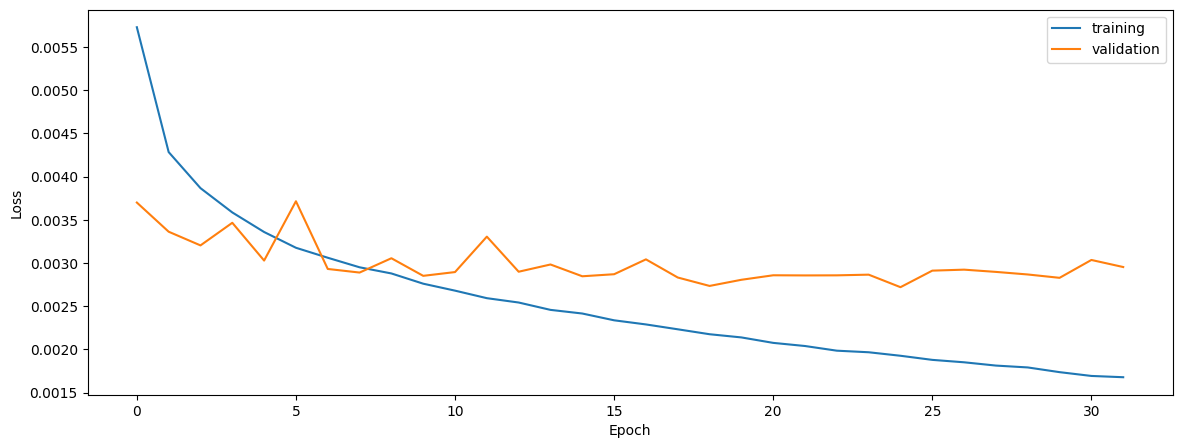

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8913155218993153
0.8327845382148462
0.8231624346652238


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.8913155218993153
0.8327845382148462
0.8231624346652238


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.8887979800252512
0.8299930356723243
0.8191714801824667


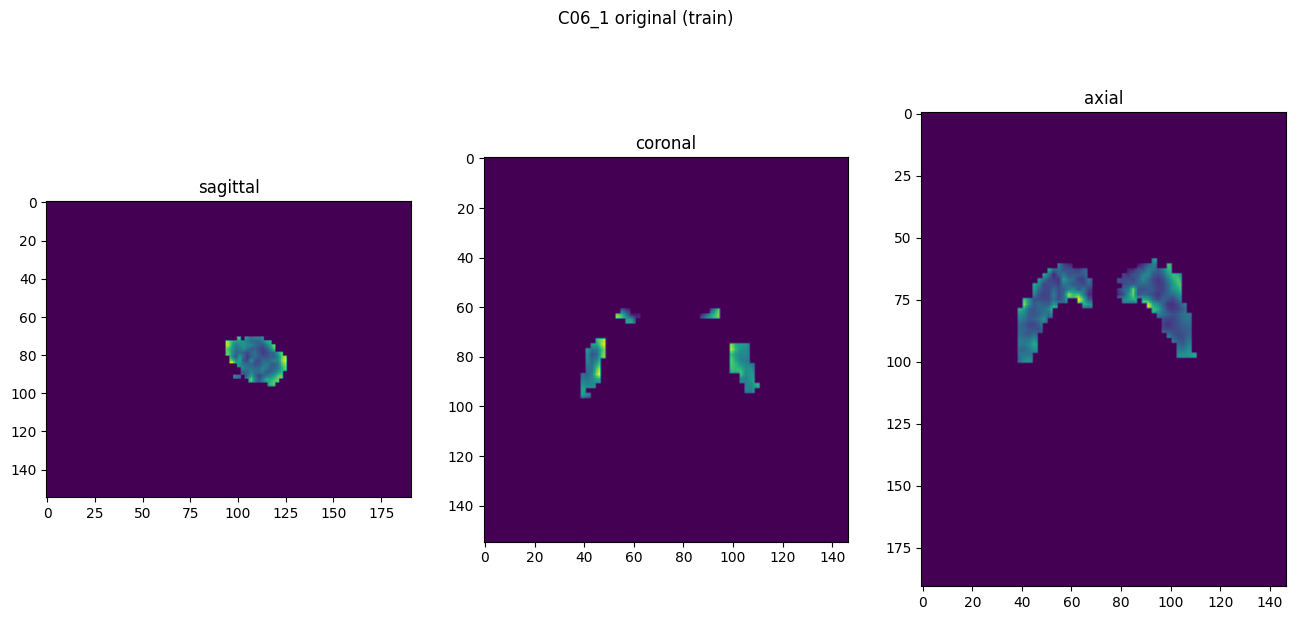

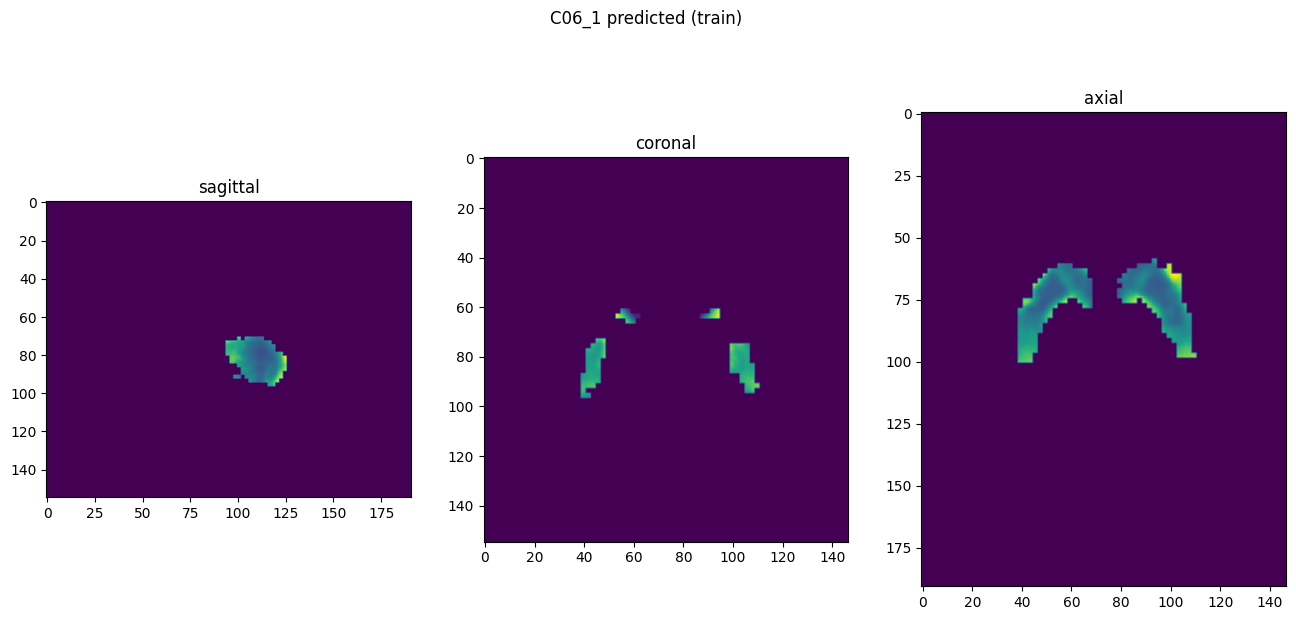

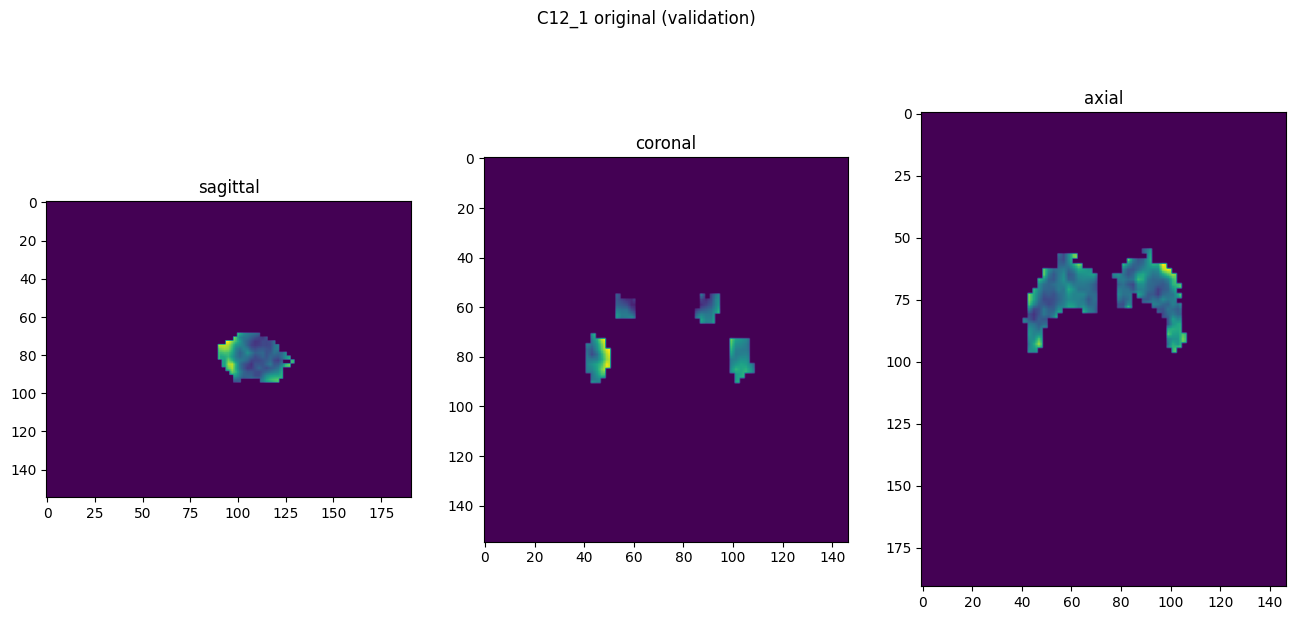

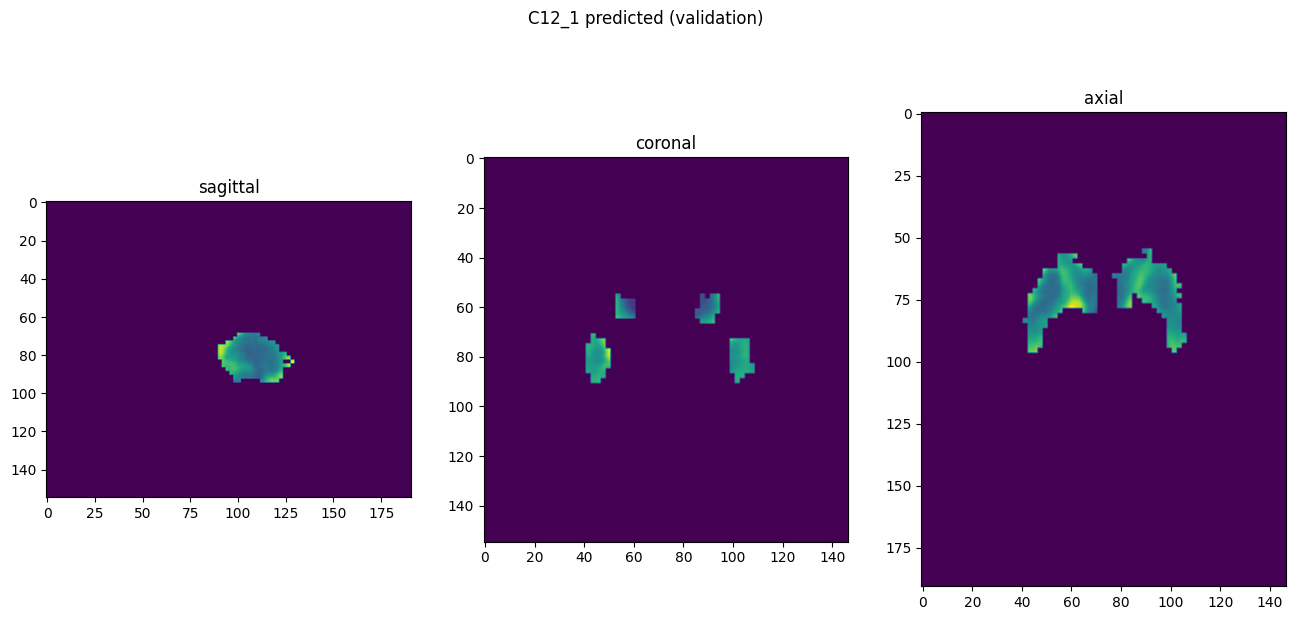

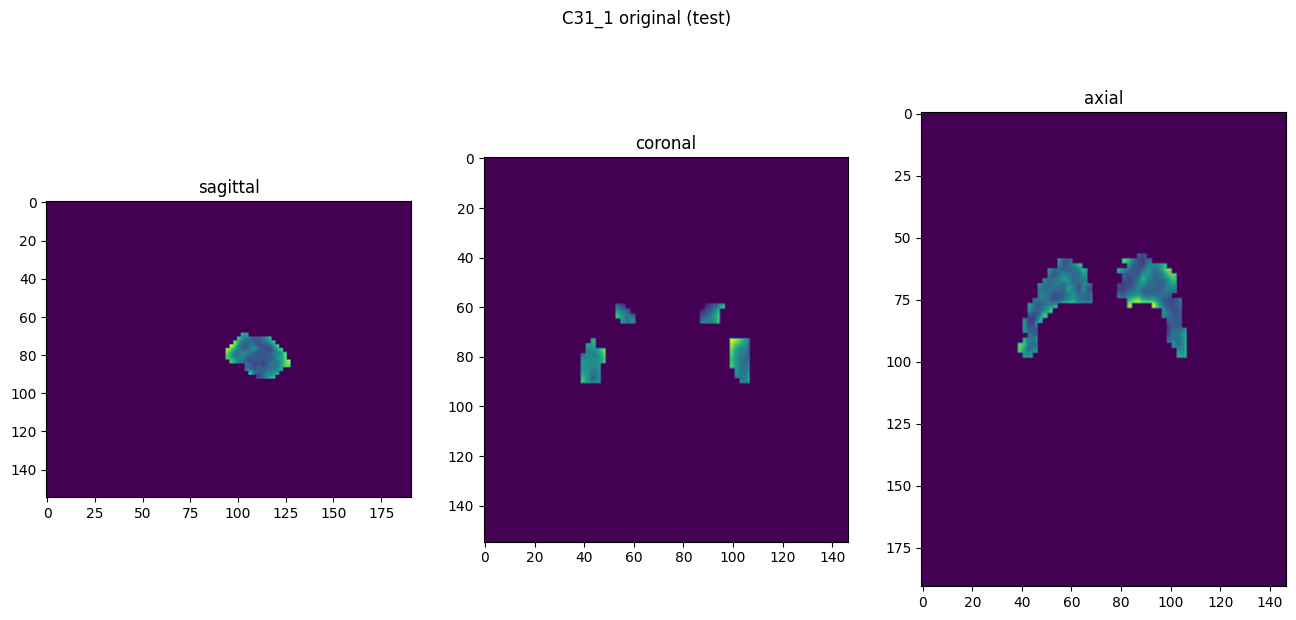

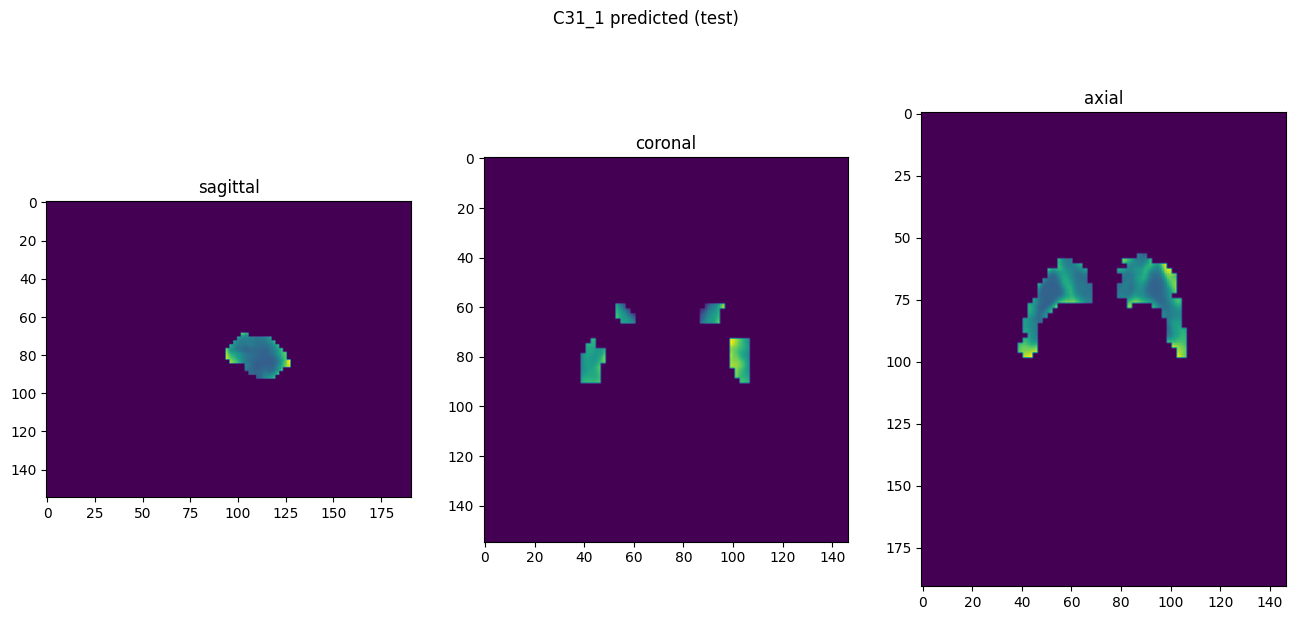

In [10]:
showResults(model, gen, threshold=None, background=False)